<img src="../../Img/img.webp" alt="Predicción del Éxito de Videojuegos" width="100%" height="300px">


<h1 style="text-align: center; font-size: 2.5em; text-decoration: underline;">MACHINE LEARNING: VALORADOR DE OPINIONES</h1>

In [3]:
# ==============================================================================
# # Manipulación de datos
# ==============================================================================

import pandas as pd
import numpy as np

# ==============================================================================
# Preprocesamiento de texto
# ==============================================================================

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# ==============================================================================
# Detección de idioma
# ==============================================================================

from langdetect import detect

# ==============================================================================
# Modelado y evaluación
# ==============================================================================

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# ==============================================================================
# Visualización
# ==============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# Guardado de modelos
# ==============================================================================

import pickle

# ==============================================================================
# Descargar recursos necesarios para nltk
# ==============================================================================

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# ==============================================================================
# Configuración warnings
# ==============================================================================

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\buque\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\buque\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\buque\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Cargar y Explorar el Dataset
Cargamos el dataset y exploramos su estructura inicial.

In [4]:
# ==============================================================================
# Load the dataset
# ==============================================================================
dataset = pd.read_csv('Data/dataset_reviews_cleaned.csv')
dataset

,Unnamed: 0,Contenido,Valoración,Recomendado_binario
0,0,2 marzo so bad,No recomendado,0
1,1,10 febrero actualmente recomiendo juego contab...,No recomendado,0
2,2,9 febrero increíblemente gracioso ver cómo cdp...,No recomendado,0
3,3,the world in this game is extremely static the...,No recomendado,0
4,4,zero replayability i finished this game in abo...,No recomendado,0
...,...,...,...,...
19995,19995,si,Recomendado,1
19996,19996,cojonudo,Recomendado,1
19997,19997,reostia historia guapisima graficos impresiona...,Recomendado,1
19998,19998,basicamente sublime obra maestra,Recomendado,1


In [3]:
# Check for missing values
missing_values = dataset.isnull().sum()

# Basic statistics of the dataset
basic_stats = dataset.describe()

missing_values, basic_stats

(Unnamed: 0               0
 Contenido              288
 Valoración               0
 Recomendado_binario      0
 dtype: int64,
          Unnamed: 0  Recomendado_binario
 count  20000.000000         20000.000000
 mean    9999.500000             0.500000
 std     5773.647028             0.500013
 min        0.000000             0.000000
 25%     4999.750000             0.000000
 50%     9999.500000             0.500000
 75%    14999.250000             1.000000
 max    19999.000000             1.000000)

In [6]:
# Eliminar registros con valores nulos en `Contenido`
dataset = dataset.dropna(subset=['Contenido'])

# Convertir el texto a minúsculas
dataset['Contenido'] = dataset['Contenido'].str.lower()

# Eliminar caracteres especiales, puntuación y dígitos
dataset['Contenido'] = dataset['Contenido'].apply(lambda x: re.sub(r'[^a-z\s]', '', x))

# Tokenización y lematización
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('spanish'))

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

dataset['Contenido'] = dataset['Contenido'].apply(preprocess_text)

dataset.head()


,Unnamed: 0,Contenido,Valoración,Recomendado_binario
0,0,marzo so bad,No recomendado,0
1,1,febrero actualmente recomiendo juego contaba r...,No recomendado,0
2,2,febrero increblemente gracioso ver cmo cdpr de...,No recomendado,0
3,3,the world in this game is extremely static the...,No recomendado,0
4,4,zero replayability i finished this game in abo...,No recomendado,0


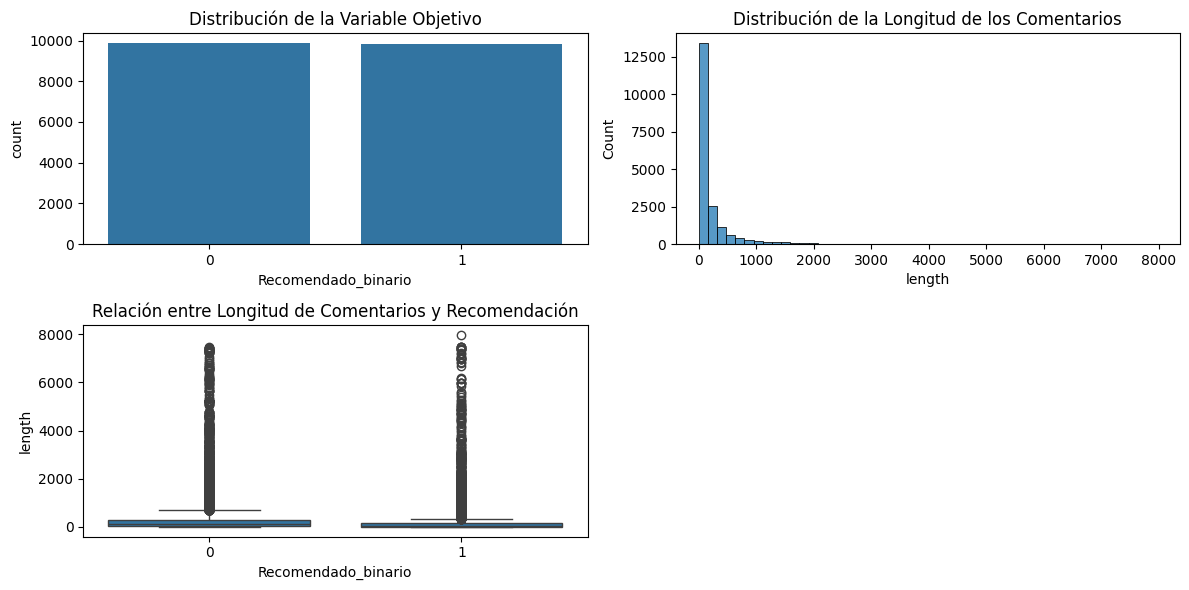

In [8]:
# EDA: Análisis Exploratorio de Datos
plt.figure(figsize=(12, 6))

# Distribución de la variable objetivo
plt.subplot(2, 2, 1)
sns.countplot(x='Recomendado_binario', data=dataset)
plt.title('Distribución de la Variable Objetivo')

# Longitud de los comentarios
dataset['length'] = dataset['Contenido'].apply(len)
plt.subplot(2, 2, 2)
sns.histplot(dataset['length'], bins=50)
plt.title('Distribución de la Longitud de los Comentarios')

# Relación entre la longitud de los comentarios y la recomendación
plt.subplot(2, 2, 3)
sns.boxplot(x='Recomendado_binario', y='length', data=dataset)
plt.title('Relación entre Longitud de Comentarios y Recomendación')

plt.tight_layout()
plt.show()

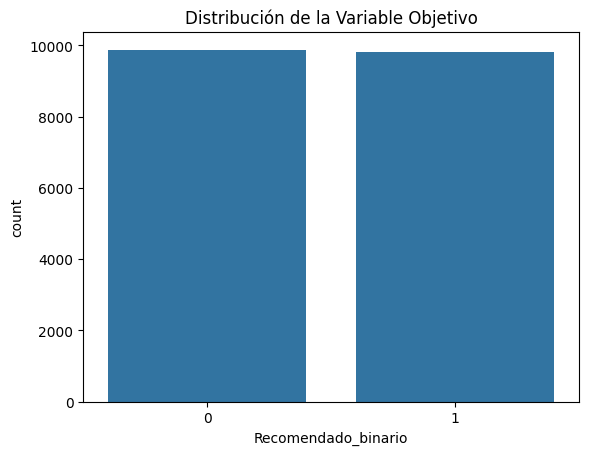

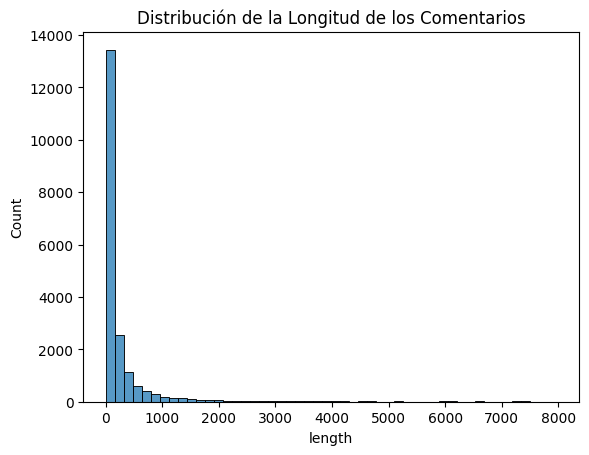

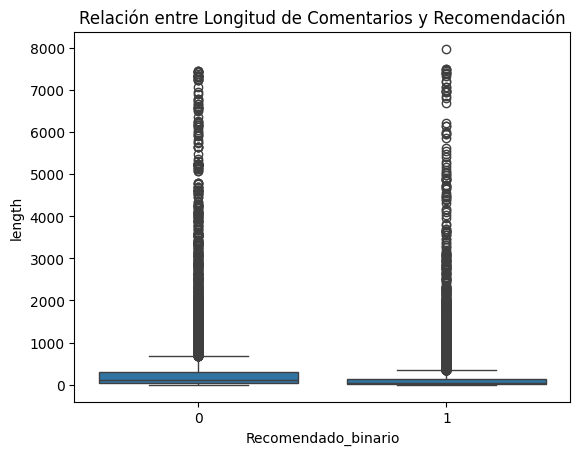

In [7]:
# Distribución de la variable objetivo
sns.countplot(x='Recomendado_binario', data=dataset)
plt.title('Distribución de la Variable Objetivo')
plt.show()

# Longitud de los comentarios
dataset['length'] = dataset['Contenido'].apply(len)
sns.histplot(dataset['length'], bins=50)
plt.title('Distribución de la Longitud de los Comentarios')
plt.show()

# Relación entre la longitud de los comentarios y la recomendación
sns.boxplot(x='Recomendado_binario', y='length', data=dataset)
plt.title('Relación entre Longitud de Comentarios y Recomendación')
plt.show()


In [5]:
# Vectorización del texto usando TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(dataset['Contenido']).toarray()
y = dataset['Recomendado_binario']


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# # Guardar los datos vectorizados y divididos
# import numpy as np

# np.save('X_train.npy', X_train)
# np.save('X_test.npy', X_test)
# np.save('y_train.npy', y_train)
# np.save('y_test.npy', y_test)

In [8]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# # Cargar los datos divididos
# X_train = np.load('X_train.npy')
# X_test = np.load('X_test.npy')
# y_train = np.load('y_train.npy')
# y_test = np.load('y_test.npy')

In [9]:
# Entrenamiento de modelos
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier()
}

In [10]:
# for model_name, model in models.items():
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     print(f"Results for {model_name}:")
#     print(classification_report(y_test, y_pred))
#     print(confusion_matrix(y_test, y_pred))
#     print(f"Accuracy: {accuracy_score(y_test, y_pred)}\n")

In [11]:
# # Evaluar el rendimiento en el conjunto de entrenamiento
# for model_name, model in models.items():
#     y_train_pred = model.predict(X_train)
#     print(f"Training Results for {model_name}:")
#     print(classification_report(y_train, y_train_pred))
#     print(confusion_matrix(y_train, y_train_pred))
#     print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred)}\n")


In [12]:
# Ajuste de Hiperparámetros para Random Forest
rf_params = {'n_estimators': [100, 200], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5, 10]}
rf_grid = GridSearchCV(RandomForestClassifier(), rf_params, cv=5, scoring='accuracy')
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

In [13]:
# Ajuste de Hiperparámetros para SVM
svm_params = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf']}
svm_grid = GridSearchCV(SVC(), svm_params, cv=5, scoring='accuracy')
svm_grid.fit(X_train, y_train)
best_svm = svm_grid.best_estimator_

In [14]:
# Evaluación de los mejores modelos
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Best SVM": best_svm,
    "Best Random Forest": best_rf
}

In [15]:
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Results for {model_name}:")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}\n")

    # Evaluación en el conjunto de entrenamiento
    y_train_pred = model.predict(X_train)
    print(f"Training Results for {model_name}:")
    print(classification_report(y_train, y_train_pred))
    print(confusion_matrix(y_train, y_train_pred))
    print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred)}\n")


Results for Logistic Regression:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      1968
           1       0.86      0.88      0.87      1975

    accuracy                           0.87      3943
   macro avg       0.87      0.87      0.87      3943
weighted avg       0.87      0.87      0.87      3943

[[1686  282]
 [ 246 1729]]
Accuracy: 0.8660918082678164

Training Results for Logistic Regression:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      7917
           1       0.89      0.90      0.90      7852

    accuracy                           0.90     15769
   macro avg       0.90      0.90      0.90     15769
weighted avg       0.90      0.90      0.90     15769

[[7060  857]
 [ 758 7094]]
Training Accuracy: 0.8975838670809817

Results for Best SVM:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1968
           1     

In [16]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
 # Validación cruzada
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Scores for {model_name}: {cv_scores}")
print(f"Mean Cross-Validation Score: {np.mean(cv_scores)}\n")


Cross-Validation Scores for Best Random Forest: [0.85700698 0.84337349 0.85288523 0.85954344 0.86140184]
Mean Cross-Validation Score: 0.8548421941559617



In [17]:
best_rf = rf_grid.best_estimator_

In [18]:
best_model_rf = best_rf if np.mean(cross_val_score(best_rf, X_train, y_train, cv=5, scoring='accuracy')) > np.mean(cross_val_score(best_rf, X_train, y_train, cv=5, scoring='accuracy')) else best_rf

with open('best_model_rf.pkl', 'wb') as file:
    pickle.dump(best_model_rf, file)

best_model_svm = best_svm if np.mean(cross_val_score(best_rf, X_train, y_train, cv=5, scoring='accuracy')) > np.mean(cross_val_score(best_rf, X_train, y_train, cv=5, scoring='accuracy')) else best_rf

with open('best_model_svm.pkl', 'wb') as file:
    pickle.dump(best_model_svm, file)


In [19]:
with open('vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)